In [1]:
import numpy as np
import matplotlib.pyplot as plt
import loupe
from keras.models import load_model
import keras
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets
import matplotlib.cm
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
plt.rcParams['image.cmap'] = 'gray'

## Load Data

In [3]:
f = np.stack(np.load('./data_2/singlecoil_train/data-100.npy'))[..., np.newaxis]
f.shape


(42, 320, 320, 1)

In [4]:
data = f

### Visualize the data

In [5]:
def visualize_function(x):
    img = data[x,:,:,0]
    plt.imshow(img);

In [6]:
interact(visualize_function,x=IntSlider(min=0, max=data.shape[0] -1, step=1));

interactive(children=(IntSlider(value=0, description='x', max=41), Output()), _dom_classes=('widget-interact',…

### Visualize the K-Space Mask

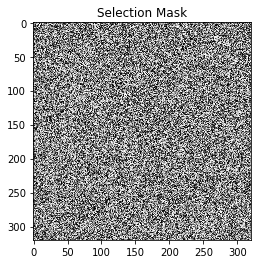

In [7]:
mask = np.load('./output/loupe_v2_mae_5_10_0.05_0.001/mask.npy')
img = mask [0, :, :, 0]
plt.figure
plt.title("Selection Mask")
plt.imshow(img)

## Reconstruct the Neural Network

In [8]:
# setup
desired_sparsity = 0.05      # desired sparsity
pmask_slope = 5              # slope for prob mask sigmoid
sample_slope = 10            # slope after sampling via uniform mask
loss = 'mae'                 # loss
vol_size = data.shape[1:-1]
model = loupe.models.loupe_model(input_shape=vol_size + (1,),
                                      filt=64,
                                      kern=3,
                                      model_type='v2',
                                      pmask_slope=pmask_slope,
                                      sparsity=desired_sparsity,
                                      sample_slope=sample_slope)

model.load_weights('./output/loupe_v2_mae_5_10_0.05_0.001/model.11.h5')
model.summary()




tracking <tf.Variable 'Variable:0' shape=() dtype=float32_ref> slope

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
tracking <tf.Variable 'Variable_1:0' shape=() dtype=float32_ref> slope


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
concat_zero (ConcatenateZero)   (None, 320, 320, 2)  0           input[0][0]                      
__________________________________________________________________________________________________
fft (FFT)                       (None, 320, 320, 2)  0           concat_zero[0][0]          

## Inferencing with the Network

In [9]:
mask_model = keras.models.Model(model.inputs, model.get_layer('prob_mask_scaled').output)
prob_mask = mask_model.predict(data)
downsampled_aa = model.predict(data)
delta = np.abs(data - downsampled_aa)

ResourceExhaustedError: OOM when allocating tensor with shape[32,320,320,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node conv_1_1/BiasAdd}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
def run_demo(x):    
    plt.figure(figsize=(15,6))
    plt.subplot(1,4,1)
    plt.imshow(data[x][:,:,0]);
    plt.title("Original Image")
    
    plt.subplot(1,4,2)
    plt.title("Probablity Mask for K-Space Selection")
    plt.imshow(prob_mask[x][:,:,0])
    
    plt.subplot(1,4,3)
    plt.title("Downsampled Image")
    plt.imshow(downsampled_aa[x][:,:,0])
    
    plt.subplot(1,4,4)
    plt.title("Difference Image")
    plt.imshow(delta[x][:,:,0])

In [ ]:
interact(run_demo,x=IntSlider(min=0, max=data.shape[0] - 1, step=1));

In [ ]:
downsampled_aa[0].max()

In [ ]:
data[0].max()